## Background

Every company has always taken pride in providing excellent customer service, therefore it's crucial as part of ongoing improvements for product to collect and analyse feedback after each customer interaction on support channels

A top-notch analyst in Hi-Tech industry should be in capable of handle at least base feedback analysis quickly and efficiently and going through this article you will be introduced with the necessary concepts and eventually given the base guide on how to unlock the true power of text data

Well, no more words, let's have a look on how 

*Disclaimer:* I'm not pretending on having this article as an exhaustive everything you need notebook for analyzing customer feedback, but it's the steps I usually follow while working on customers text data and on the basis of my previous experience - 80% of your needs is covered here

### Prerequisites

It's expected that the reader has an experience with Python and it's main Data Analysis libraries

The actual notebook was written on Python 3.7.9 and to keep the results reproducible here is the list of particular packages that are being used in the article specified with their versions

In [ ]:
numpy==1.21.6
pandas==1.3.5
pandas-profiling==3.1.0
matplotlib==3.4.2
unidecode==1.3.7
nltk==3.6.2
sklearn==0.24.2
wordcloud==1.9.2
shap==0.42.1
transformers==4.30.2
gensim==4.0.1

### Methodology

During this notebook the feedback which comes in the form of ratings (from 1-5) and textual comments is considered. The general purpose is to dive deeper into this feedback, identify common themes, if certain issues lead to more negative feedback than others and understand areas of improvement

In [2]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
%matplotlib inline

As a general rule the analysis should be organized in a top-down manner, simple exploration and low-hanging fruits first and sophisticated approach after only if you really need more in-depth expertise. According to the above the analysis will be organized in the three steps:

1. Data Mining - simple unsupervised data exploration to have a general idea of the data nature
2. Sentiment Analysis - search on what matters the most which reasons drive review to be positive or negative
3. Topic Modelling - main feedback themes extraction, improvement focuses identification

## Analysis Process

### Data Mining

#### Basic EDA

First of all - let's have a fluent look at the suggested data, `pandas-profiling` is a very useful tool to perform basic and boring Exploratory Data Analysis in a minute. View [Data Profile](./data-profile.html) by clicking here

In [3]:
from pandas_profiling import ProfileReport

df = pd.read_csv('feedback-data-sample.csv', index_col=0)

profile = ProfileReport(
    df,
    minimal=True,
    dark_mode=True,
    title="Feedback Data Report",
)

profile.to_file("data-profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Well, what are the main data patterns
 - the dataset constitutes 1276 tickets with customer feedback consisted of `csat_score` and `comment`
 - `ticket_id` - is a primary key, given that we don't have timestamp column and it's looks like bigint not a random hash, it's better to sort by it beforehand, to be sure we are not predicting the past on the future features
 - all the reviews are in English `language`, good for us, we can forget about additional translators and this column in general
 - `csat_score` has only two different values 0 and 4 stars, and the majority of reviews are positive, well not much, but it's even easier to transform it into a bool target and work with it further
 - `comment` has a few NULL values, let's keep it in mind
 - from the simple frequentist analysis it's clear that tokens `not` and `very` might be informative, so don't forget to exclude them from stop words list

In [4]:
df = df.sort_index().drop(columns={'language'})

def define_sentiment(rating: float) -> int:
    if rating < 3:
        return -1 # negative sentiment
    elif rating > 3:
        return 1 # positive sentiment
    else:
        return 0 # neutral sentiment

df['sentiment'] = df['csat_score'].apply(define_sentiment)

#### Text cleaning

Barely the role of data cleaning might be underestimated, it's an incredibly important step, if this is skipped the rest of analysis doesn't make any sense then.

Main cleaning that should be applied:
 - remove all the symbols and keep only words
 - remove redundant short words
 - remove general language words
 - transliterate unicode symbols to ascii
 - lowercase
 
The next step is tokenization: the are two main approaches here:
 - stemming - fast process of removing prefixes and suffixes to give a word a short form, that might not be a dictionary word though
 - lemmatization - finds meaningful word representation from dictionary and depends on the part-of-speech
 
To summarize, the stemming is just searching for a common ground between words and cutting ends then and therefore it takes less time whereas lemmatization provides better results by performing a specific morphological analysis and produces a real word which is extremely important for some human-interactive applications

Sounds like if the resources are not a problem it's better to use lemmatization by default, but there is an opinion that Stemming works efficiently for some specific tasks like: spam classification and feedback sentiment classification, given that it's the case, let's apply both and take a choice in the end

In [5]:
import re
import nltk

# If the code below doesn't work - download add-ons first
# nltk.download(['stopwords', 'wordnet'])

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# this words might be useful, better to retain for now
for word in ['very', 'not']:
    stop_words.remove(word)

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# better version of the Porter Stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

for example in ['programming', 'quickly', 'very']:
    print(f"Example: {example}")
    print(f" - Lemma: {lemmatizer.lemmatize(example, pos='v')}")
    print(f" - Stem: {stemmer.stem(example)}")

Example: programming
 - Lemma: program
 - Stem: program
Example: quickly
 - Lemma: quickly
 - Stem: quick
Example: very
 - Lemma: very
 - Stem: veri


Unicode transliteration is needed, given that the data contains non-ascii symbols

In [6]:
from unidecode import unidecode

df[df.comments.notnull()][
    df[df.comments.notnull()].comments != df[df.comments.notnull()].comments.apply(unidecode)
].comments.sample(5)

ticket_id
43532202076873    Just asking me to show what I’m doing to give ...
43532202076331                                I haven’t had a reply
43532202117219                                    All good 👍 thanks
43532202073174    Chat went silent. After talking to someone the...
43532202202546    Hi Valéria,\nIt still does not work. There mus...
Name: comments, dtype: object

Putting it all together

In [7]:
def clean_data(x, tokenizer, black_list=stop_words):
    """
    The method removes from a sentence `x`
     - punctuation & digits
     - too short words (less than 3 letters)
     - unicode symbols (translate to ascii)
     - words from `black_list`
    Return lowercased and tokenized text
    """
    words = re.findall('\w{3,}', re.sub('[^a-zÀ-ÿ ]', ' ', str(x).lower() if x is not np.NaN else ''))
    tokens = [tokenize(unidecode(word), tokenizer) for word in words]
    return ' '.join([word for word in tokens if word not in black_list])


def tokenize(x: str, tokenizer) -> str:
    """
    Applies either stemming or lemmatization to a token `x`
    """
    if hasattr(tokenizer, 'lemmatize'):
        return tokenizer.lemmatize(x, pos='v')
    elif hasattr(tokenizer, 'stem'):
        return tokenizer.stem(x)
    else:
        raise ValueError("tokenizer should be either Lemmatizer or Stemmer")


df["lemma_text"] = df.comments.apply(clean_data, args=(lemmatizer,))
df["stem_text"] = df.comments.apply(clean_data, args=(stemmer,))

#### Words Frequency

There are many different ways how to tackle the visual text analysis, the popular and convenient way is Word Clouds where the size of the word reflects its frequency within the given text

P.S. In any data mining initiative, it is a good idea to retain some portion of the data to validate your final findings, so let's create a holdout piece of data to adhere true-to-life approach

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[["lemma_text", "stem_text"]],
    df['sentiment'],
    train_size=1000,
    shuffle=False
)

from collections import Counter

def create_ngrams(tokens: list, n: int):
    ngrams = zip(*[tokens[idx:] for idx in range(n)])
    return [" ".join(sorted(ngram)) for ngram in ngrams]


def frequent_ngrams(documents: list, n: int = 1):
    """
    Use .most_common(top_n) to get top n ngrams
    """
    ngrams = []
    if n == 1:
        ngrams = " ".join(list(documents)).split()
    elif n >= 2:
        for tokens in documents:
            ngrams.extend(create_ngrams(tokens.split(), n))
    else:
        raise ValueError("n for n-grams should be a positive number")
    return Counter(ngrams)


import wordcloud

def make_word_cloud(text, stop_words=None):
    plt.figure(figsize=(12, 9))
    kwargs = {
        'width': 1600,
        'height': 900,
        'min_font_size': 10
    }
    if isinstance(text, str):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words, **kwargs).generate_from_text(text)
    elif isinstance(text, list) or isinstance(text, np.ndarray):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words, **kwargs).generate(" ".join(text))
    else:
        if stop_words:
            text = {word: value for word, value in text.items() if word not in stop_words}
        word_cloud = wordcloud.WordCloud(**kwargs).generate_from_frequencies(text)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

First of all, as promised different tokenizers should be compared

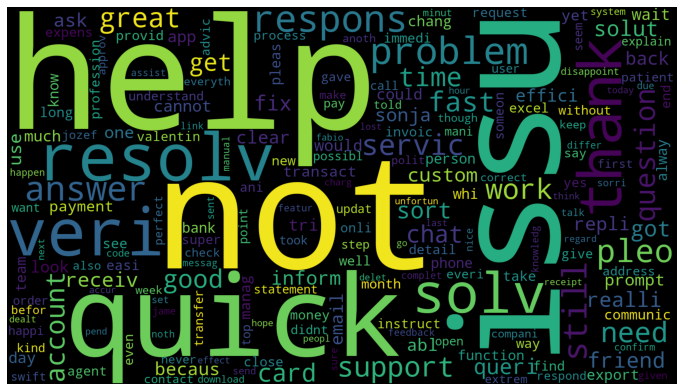

In [53]:
make_word_cloud(frequent_ngrams(X_train["stem_text"], 1))

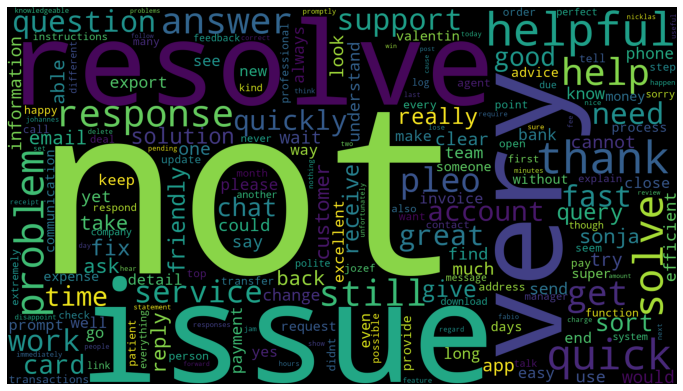

In [54]:
make_word_cloud(frequent_ngrams(X_train["lemma_text"], 1))

Well, at first glance it looks like both tokenizers work very similarly, one noticeable difference is that stemmer treats word pairs like `help` and `helpful` or `quick` and `quickly` as one token and actually it might be wrong, imagine if we encounter `helpful` more in positive sentence and `help` in negative, then they shouldn't be united

In [9]:
for word in ["help", "helpful"]:
    score = df.loc[
        df["comments"].apply(
            lambda x: f" {word} " in x if x is not np.nan else False
        ), "sentiment"
    ].mean()
    print(f"for `{word}` average sentiment score = {score:.2f}")

for `help` average sentiment score = 0.31
for `helpful` average sentiment score = 0.95


Indeed, that is the case, so let's end up with traditional lemmatizer and take a look at word clouds separately for different sentiments

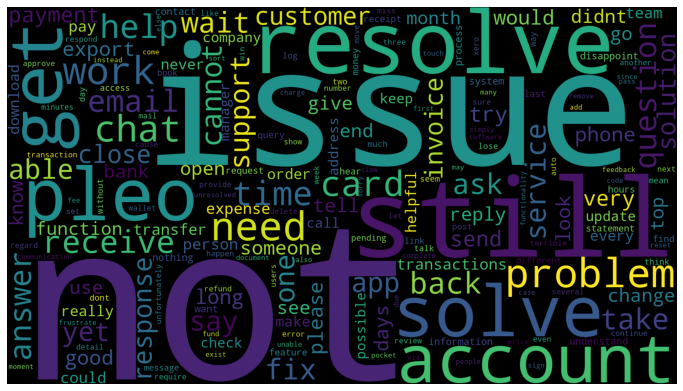

In [56]:
make_word_cloud(frequent_ngrams(X_train.loc[y_train < 0, "lemma_text"], 1))

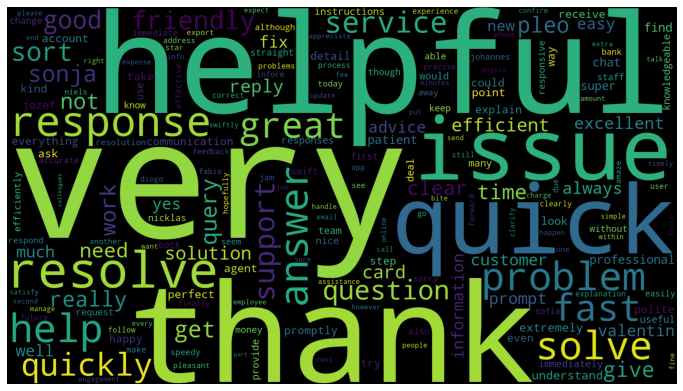

In [57]:
make_word_cloud(frequent_ngrams(X_train.loc[y_train > 0, "lemma_text"], 1))

Good news, they are very different in essence, in positive reviews customers use gratitude words more like `thank` and `helpful` on the other hand in negative sentences customer highlight that the `issue` `still` `not` `resolved`. In addition it might be useful to take a look at popular collocations

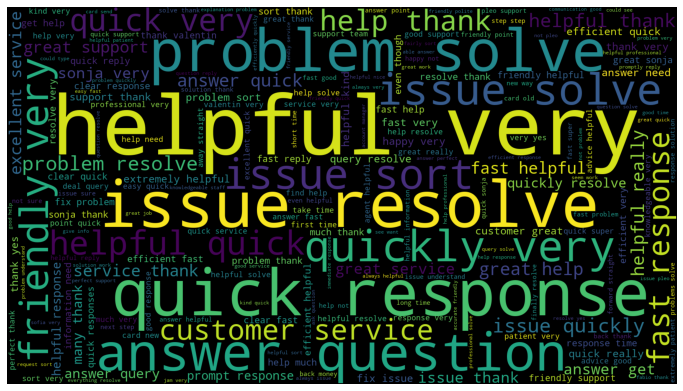

In [58]:
make_word_cloud(frequent_ngrams(X_train.loc[y_train > 0, "lemma_text"], 2))

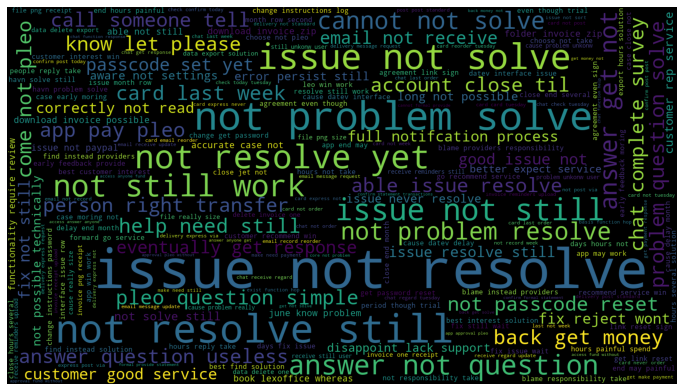

In [59]:
make_word_cloud(frequent_ngrams(X_train.loc[y_train < 0, "lemma_text"], 3))

N-grams appear to be very informative:
 - in positive sentences, based on bigrams, customers say that the `response` was `quick`, `problem` was `solved` and the support was `very helpful`
 - in negative sentences, on the basis of trigrams, customers claim that the `issue`/`problem` `not` `resolved` sometimes the add `yet` or `still` to fully express their dissatisfaction
 
To summarize, the basic approach has already given some meaningful insights and the hope that the reviews might be classified automatically quite well and themes can be modelled then

#### Unsupervised TF-IDF

It's critical to reduce feature number otherwise X-matrix will be too sparse, and the clusterization will fail to give a substantial result, actually only quite often words should be taken into account

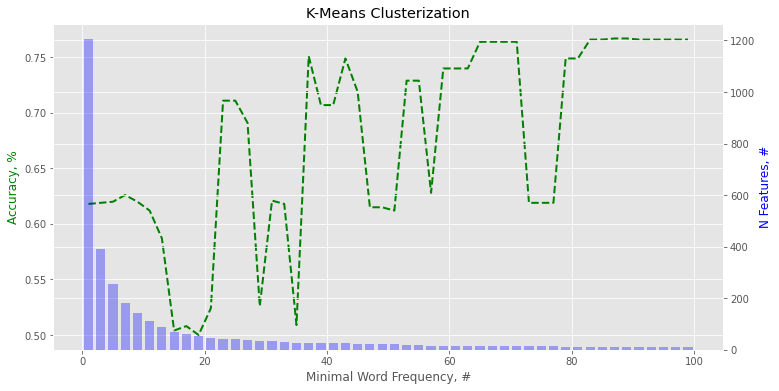

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

min_word_counts = range(1, 100, 2)
n_features, scores = [], []
for min_word_count in min_word_counts:
    tfidf = TfidfVectorizer(min_df=min_word_count)
    X = tfidf.fit_transform(X_train["lemma_text"])
    n_features.append(X.shape[1])
    km = KMeans(
        n_clusters=2,
        init='k-means++',
        max_iter=300,
        random_state=20231020
    )
    km.fit(X)
    score = accuracy_score(2 * km.predict(X) - 1, y_train)
    scores.append(
        max(score, 1 - score)
    )

plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax2.bar(min_word_counts, n_features, color="b", width=1.5, alpha=0.33)
ax1.plot(min_word_counts, scores, "g--", linewidth=2)

ax1.set_ylabel('Accuracy, %', color="g")
ax1.set_xlabel('Minimal Word Frequency, #')
ax2.set_ylabel('N Features, #', color="b")
plt.title('K-Means Clusterization')
plt.show()

From the chart is clear that the larger number of features doesn't lead to the Accuracy increase, from the principal of maximum Accuracy the optimal number of features might be 69 for example, let's fix it and track which features the model decided to consider

In [11]:
tfidf = TfidfVectorizer(min_df=69)
X = tfidf.fit_transform(X_train["lemma_text"])
words = np.array(tfidf.get_feature_names())

print(f"Number of features: {X.shape[1]}, namely: ")
print(*words)

Number of features: 14, namely: 
answer get help helpful issue not problem quick resolve response solve still thank very


The clusterization which is based just on __14 words!__ gives an accuracy higher than 75%, but it's the result only valid for the train sample, which was used to identify `min_df` hyperparameter, so to have an unbiased estimation test sample should be considered here

In [62]:
km = KMeans(
    n_clusters=2,
    init='k-means++',
    max_iter=300,
    random_state=20231020
)

km.fit(X)

centroids_important_indexes = km.cluster_centers_.argsort()[:,::-1]

for idx in range(km.get_params()['n_clusters']):
    print("Cluster No.", idx, *words[centroids_important_indexes[idx, :7]])

Cluster No. 0 very issue thank helpful quick resolve response
Cluster No. 1 not issue resolve still solve problem get


Well, looks like Cluster-0 caught positive feedback and Cluster-1 negative, then given that target is the value from [-1, 1] set, to define an accuracy some transformation must be put in place first

In [63]:
predictions_train = 2 * -km.predict(X) + 1

print(f"Accuracy of K-Means train sample = {accuracy_score(predictions_train, y_train):.1%}")

Accuracy of K-Means train sample = 76.4%


In [64]:
predictions_test = 2 * -km.predict(
    tfidf.transform(
        X_test["lemma_text"]
    )
) + 1

print(f"Accuracy of K-Means test sample = {accuracy_score(predictions_test, y_test):.1%}")

Accuracy of K-Means test sample = 74.6%


Splendid, this toy example gives a clue that it's pretty good approach when you need to classify your customer's feedback while you don't have any ratings (only text comments). Unsupervised approach based on TF-IDF Vectorizer and K-Means gives a nice baseline, but fortunately, it's not our case let's go ahead and use rating set by a customer in addition to texts to reach the text data potential

### Sentiment Analysis

The goal of this part of the article is to enhance the unsupervised model and build a powerful classifier to eventually understand key drivers for review to be positive or negative from features extraction

There are 2 main ways of doing Semantic Analysis:
 - train your own model using the available data
 - use pre-trained deep learning models and fine-tune them if needed for this particular text specific
 
Both approaches is considered below

#### Custom Regression Model

Training of the custom model will be held in 3 steps (again?)
 - Model architecture selection
 - Selected model training and cross-validation
 - Feature analysis and general evaluation

Well, by the `model` term stands combination of Vectorizer, which transform text data into a vector representation and Classifier that is training on these vectors to predict sentiment

Out of vectorizers we are going to try both most popular options: Classic Counter and TF-iDF,  for classificators let's search among classic linear, tree-based and in addition naive bias method, which might be extremely useful for text classification

In addition as it was shown during unsupervised analysis, barely all the words should be taken into account to build a substantial model and it alleviates the learning process also, therefore SVD application for feature space reduction will be considered

In [65]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from typing import List, Union, Optional

def model(vectorizer, classifier, transformer=None):
    if transformer:
        return Pipeline([
            ("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)
        ])
    else:
        return Pipeline([
            ("vectorizer", vectorizer),
            ("classifier", classifier)
        ])


def get_entity_name(entity: Union[List[object], Optional[object]]) -> str:
    if not isinstance(entity, List):
        entity = [entity]
    return [re.sub(">|'", '', str(e)).split(".")[-1] for e in entity if e]

Using vanilla classifiers let's define which one suits the data better from scratch and reveal hyperparameters on the validation basis after for this candidate

In [73]:
np.random.seed(20231024)

for vectorizer in [CountVectorizer, TfidfVectorizer]:
    for classifier in [LogisticRegression, SGDClassifier, RandomForestClassifier, LinearSVC, MultinomialNB]:
        transformers = [None]
        if vectorizer == CountVectorizer:
            transformers.append(TfidfTransformer())
        if classifier != MultinomialNB:
            transformers.extend([
                TruncatedSVD(n_components=100),
                TruncatedSVD(n_components=10),
            ])
        for transformer in transformers:
            print(get_entity_name([vectorizer, classifier, transformer]), end=": ")
            score = cross_val_score(
                model(vectorizer(), classifier(), transformer),
                X_train["lemma_text"],
                y_train,
                cv=5,
                scoring='f1'
            ).mean()
            print(f"f1-score: {score:.1%}")

['CountVectorizer', 'LogisticRegression']: f1-score: 90.2%
['CountVectorizer', 'LogisticRegression', 'TfidfTransformer()']: f1-score: 90.5%
['CountVectorizer', 'LogisticRegression', 'TruncatedSVD(n_components=100)']: f1-score: 88.7%
['CountVectorizer', 'LogisticRegression', 'TruncatedSVD(n_components=10)']: f1-score: 87.5%
['CountVectorizer', 'SGDClassifier']: f1-score: 88.0%
['CountVectorizer', 'SGDClassifier', 'TfidfTransformer()']: f1-score: 89.5%
['CountVectorizer', 'SGDClassifier', 'TruncatedSVD(n_components=100)']: f1-score: 88.0%
['CountVectorizer', 'SGDClassifier', 'TruncatedSVD(n_components=10)']: f1-score: 84.7%
['CountVectorizer', 'RandomForestClassifier']: f1-score: 90.2%
['CountVectorizer', 'RandomForestClassifier', 'TfidfTransformer()']: f1-score: 90.1%
['CountVectorizer', 'RandomForestClassifier', 'TruncatedSVD(n_components=100)']: f1-score: 89.1%
['CountVectorizer', 'RandomForestClassifier', 'TruncatedSVD(n_components=10)']: f1-score: 88.3%
['CountVectorizer', 'LinearSV

Winners: 
 - TfidfVectorizer & LinearSVC & TruncatedSVD 
 - CountVectorizer & MultinomialNB
 - TfidfVectorizer & LogisticRegression
 
On the basis of above analysis, the better approach will be to go with the first option because:
 1. there is a clear rationale to apply tf-idf over usual counter for the majority of text analysis task
 2. regression is more flexible model than Naive Bayes and highly likely that after cross-validation it can accomplish even higher accuracy
 3. reducing the feature space makes sense as it was for unsupervised learning

In [407]:
from sklearn.model_selection import GridSearchCV

clf = model(
    vectorizer=TfidfVectorizer(),
    classifier=LinearSVC(random_state=20231020),
    transformer=TruncatedSVD()
)

param_grid = {
    "vectorizer__max_df": [1.0, 0.15, 0.10],
    "vectorizer__min_df": [1, 2, 3],
    "vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)],
    "classifier__C": [0.75, 1, 1.25],
    "transformer__n_components": [100, 500, 1000]
}
search = GridSearchCV(clf, param_grid, cv=3)
search.fit(X_train["lemma_text"], y_train)
print("Best parameter (CV score = %0.3f):" % search.best_score_)
for key, value in search.best_params_.items():
    print(f"{key}: {value}")

Best parameter (CV score = 0.897):
classifier__C: 1
classifier__loss: hinge
transformer__n_components: 1000
vectorizer__max_df: 1.0
vectorizer__min_df: 1
vectorizer__ngram_range: (1, 2)


In [408]:
# If you want to see all the results of the scoring use the following code
# for param, score in zip(
#     search.cv_results_['params'],
#     search.cv_results_['mean_test_score']
# ):
#     print(param, score)

The majority of parameters remains as by default, although some of them changed, it's interesting that only bigrams are useful, trigrams on contrary to what we saw before from dummy analysis don't give any additional info to regression from grid-search point of view, from given experience it's better to retain them

Well, given the parameters are all defined, let's set them up and take closer look at the trained model 

In [124]:
from sklearn.metrics import classification_report

clf = model(
    vectorizer=TfidfVectorizer(ngram_range=(1, 3)),
    classifier=LinearSVC(random_state=20231020),
    transformer=TruncatedSVD(n_components=1000),
)

clf.fit(X_train["lemma_text"], y_train)
print(classification_report(y_test, clf.predict(X_test["lemma_text"])))

              precision    recall  f1-score   support

          -1       0.90      0.86      0.88       111
           1       0.91      0.94      0.92       165

    accuracy                           0.91       276
   macro avg       0.91      0.90      0.90       276
weighted avg       0.91      0.91      0.91       276



If we just out of curiosity take a look at another candidate - Naive Bayes, then the results are

In [125]:
clf = model(
    vectorizer=CountVectorizer(ngram_range=(1, 3)),
    classifier=MultinomialNB(),
)

clf.fit(X_train["lemma_text"], y_train)
print(classification_report(y_test, clf.predict(X_test["lemma_text"])))

              precision    recall  f1-score   support

          -1       0.90      0.82      0.86       111
           1       0.89      0.94      0.91       165

    accuracy                           0.89       276
   macro avg       0.89      0.88      0.89       276
weighted avg       0.89      0.89      0.89       276



Well, regression works a bit better and it's a pretty powerful classificator, but what is really needed is feature exploration, which words have been determined by the model sentiment and what do customers really appreciate or complain about. In order to evaluate features easily SVD step is skipped here, it doesn't inflict tangible damage on model quality but simplifies analysis a lot

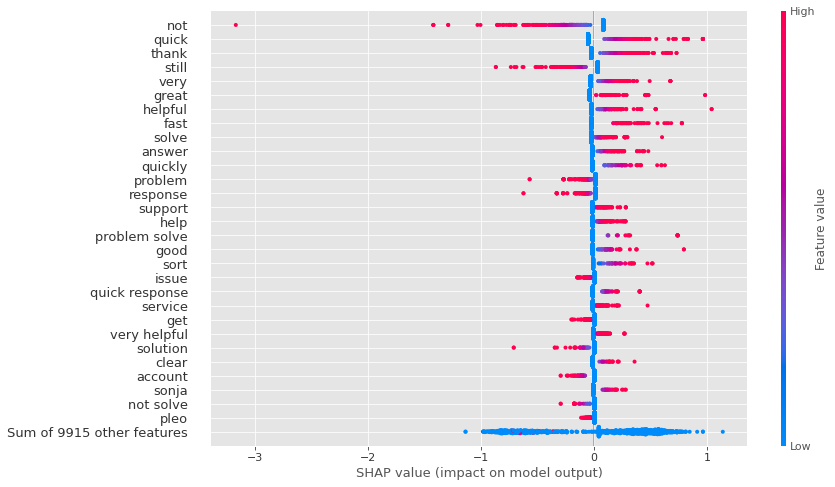

In [128]:
import shap

vectorizer=TfidfVectorizer(ngram_range=(1, 3))
classifier=LinearSVC(random_state=20231020)

X_train_vec = vectorizer.fit_transform(X_train["lemma_text"])
classifier.fit(X_train_vec, y_train)

explainer = shap.Explainer(
    classifier, X_train_vec, feature_names=vectorizer.get_feature_names()
)
shap_values = explainer(X_train_vec)

shap.plots.beeswarm(shap_values, max_display=30, plot_size=(12, 8))

Well, the results almost don't reveal any new pattens:
 - clients like quick and clear answered questions, they are thankful for fast and friendly support and of course solved problem is everything
 - clients dislike: if have no response (reply) and if the problem still not resolved (yet), in general they don't like to wait for getting a solution

However, there are some new words here - account, pleo and sonja, and there is an easy way to check how the model works for a particular review

P.S. if visualization doesn't work run `shap.initjs()` first

In [145]:
for word in['account', 'pleo', 'sonja']:
    print(word, *X_train["lemma_text"].apply(lambda x: word in x).values.argsort()[-3:])

account 154 375 104
pleo 386 532 242
sonja 826 943 190


Negative
Text: my email account is still not connected and it does not work. tried a couple of times to reconnect


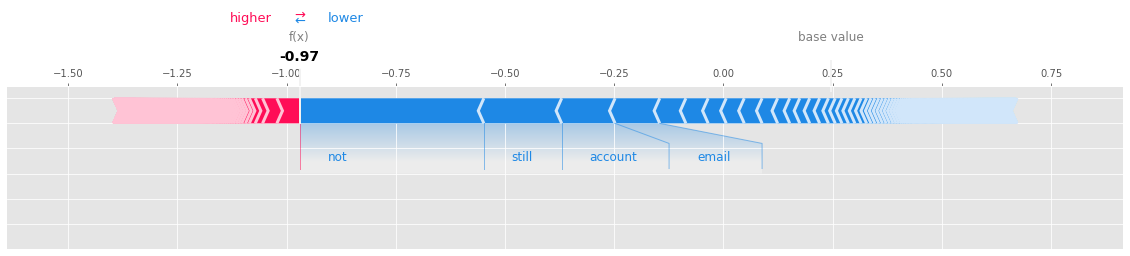

In [136]:
idx = 154
print('Positive' if y_train.values[idx] > 0 else 'Negative')
print('Text:', df.iloc[idx]["comments"])
shap.plots.force(
    explainer.expected_value,
    shap_values.values[idx],
    feature_names=vectorizer.get_feature_names(),
    matplotlib=True,
)

Positive
Text: Fast answer and a perfect answer because the function I was looking for was in Pleo :D



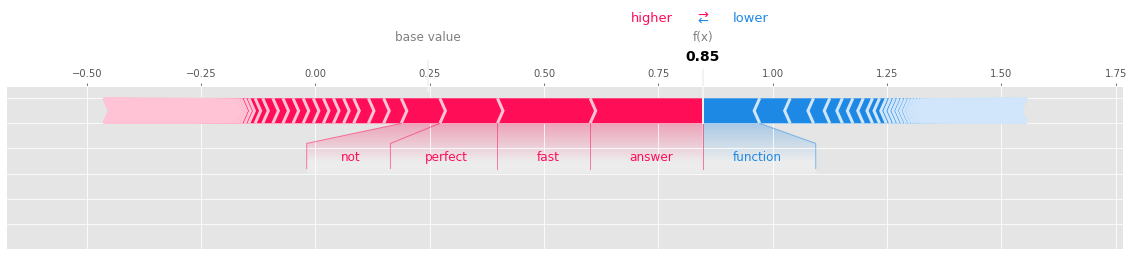

In [144]:
idx = 242
print('Positive' if y_train.values[idx] > 0 else 'Negative')
print('Text:', df.iloc[idx]["comments"])
shap.plots.force(
    explainer.expected_value,
    shap_values.values[idx],
    feature_names=vectorizer.get_feature_names(),
    matplotlib=True,
)

Positive
Text: Quick and thorough answer by support agent Sonja!


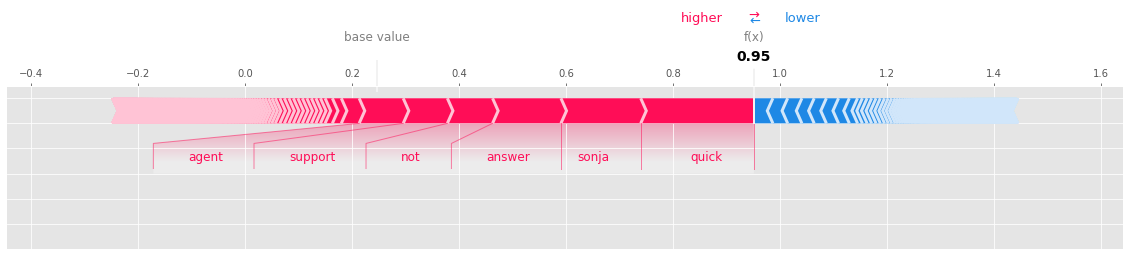

In [138]:
idx = 826
print('Positive' if y_train.values[idx] > 0 else 'Negative')
print('Text:', df.iloc[idx]["comments"])
shap.plots.force(
    explainer.expected_value,
    shap_values.values[idx],
    feature_names=vectorizer.get_feature_names(),
    matplotlib=True,
)

From several examples it comes that:
 - `account` word usually means a general problem with account
 - `pleo` appears in formal reviews, mostly with some claim
 - `sonja` seems to be a chat bot agent and it gets positive reviews

#### Pretrained neural network

Well, we got some new insights using custom model approach, let's see whether the modern NN architecture will be able to unlock even more meaningful take-away's without additional training

In [99]:
from transformers import pipeline

sentiment_transformer_model = pipeline(
    task="sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    return_all_scores=True
)

scoring_results = sentiment_transformer_model(X_test["lemma_text"].to_list())

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The drawback of this approach becomes obvious as soon as you start applying it, even inference is taking a lot of time, fingers crossed it's worths it, let's look at the classification quality

In [100]:
def twitter_roberta_predict(scoring_output):
    scoring_output.sort(key=lambda x: x['score'], reverse=True)
    prediction = scoring_output[scoring_output[0]['label'] == 'neutral']['label']
    if prediction == "positive":
        return 1
    elif prediction == "negative":
        return -1
    else:
        raise ValueError("unexpected scoring results")

sentiment_transformer_predictions = [twitter_roberta_predict(scoring) for scoring in scoring_results]

print( classification_report(y_test, sentiment_transformer_predictions) )

              precision    recall  f1-score   support

          -1       0.19      0.23      0.21       111
           1       0.38      0.32      0.35       165

    accuracy                           0.29       276
   macro avg       0.29      0.28      0.28       276
weighted avg       0.31      0.29      0.29       276



It's kind of expected, given that we use the model which was trained and fine tuned on the texts which have a bit different nature (tweets). To unlock the true power of neural network approach it should be fine tuned to reflect the particular data specific and if you don't have the sufficient amount of data - it should be a red flag not to wasting time with too comprehensive models

Anyway, let's take a look on how the language model works before pigeonholing it, here we are just some examples, to get a better summary a larger portion of the dataset is needed

In [101]:
explainer = shap.Explainer(sentiment_transformer_model)

shap_values = explainer(
    X_train.loc[X_train["lemma_text"].apply(lambda x: len(x.split()) > 5), "lemma_text"].sample(3),
    silent=True
)

shap.plots.text(shap_values)

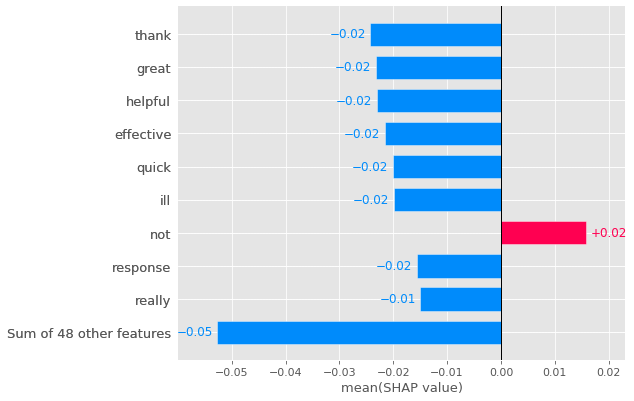

In [107]:
shap_values = explainer(
    X_train["lemma_text"].sample(10),
    silent=True
)

shap.plots.bar(
    shap_values[:, :, "positive"].mean(axis=0),
    # max_display=10,
    # order=shap.Explanation.argsort,
)

The shap library is a very powerful tool to analyze text data, the logic which is hidden by many layers of the neural network might be easily and explicitly reflected, just wait

Given that the model isn't very precise, there isn't much sense in detailed analysis of its work, let's go to the next step and keep in mind that the neural network altogether with shap is a very convenient tool to analyze texts in case of large datasets

### Topic Modelling

The final section is devoted to the topic modelling problem. It's a family of algorithms that allows you to build the topics distribution model for the corpus of texts in an unsupervised manner. 

The idea is to analyze positive and negative feedback separately and retrieve the things that customers appreciate in the support and the improvement focuses respectively. For now the focus will be on negative feedback, because it's more critical to identify the potential process problem whereas the positive feedback isn't as informative, apparently it should be modeled too if time permits

Here for topic modelling is used one of the well-known model - LDA

In [108]:
from gensim import corpora, models

data = df.loc[df["sentiment"] < 0, "lemma_text"].apply(str.split)
texts = data.to_list()
indexes = data.index

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

Coherence is the metric that is most correlated with an external human assessment quality metric and hopefully it can be calculated without any manual interposition hence it's very useful to determine the optimal topic number

In [46]:
np.random.seed(20231025)
topics = range(2, 8)
out = []

for t in topics:
    ldamodel = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=t, passes=20)
    print('Topic Num =', t, end = ' ')
    coherence = ldamodel.top_topics(texts=texts, window_size=10, coherence='c_uci')
    avg_coherence = 0
    for topic in range(len(coherence)):
        avg_coherence += coherence[topic][1] / len(coherence)
    print('Coherence = {:.2f}'.format(avg_coherence))
    out.append(avg_coherence)

Topic Num = 2 Coherence = -4.26
Topic Num = 3 Coherence = -3.88
Topic Num = 4 Coherence = -4.21
Topic Num = 5 Coherence = -4.72
Topic Num = 6 Coherence = -4.54
Topic Num = 7 Coherence = -5.01


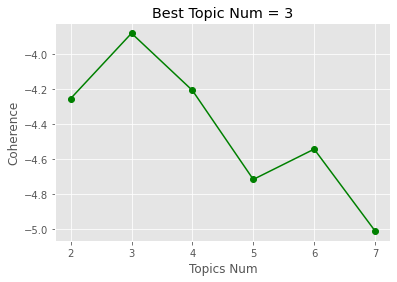

In [47]:
plt.plot(topics, out, "go-")
plt.title(f"Best Topic Num = {topics[np.array(out).argmax()]}")
plt.ylabel("Coherence")
plt.xlabel("Topics Num")
plt.show()

Well, let's build the model for 3 topics then as it provides the highest value of coherence

In [109]:
np.random.seed(20231025)
ldamodel = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=3, passes=20)
ldamodel.show_topics(num_topics=ldamodel.num_topics, num_words=5, formatted=True)

[(0,
  '0.021*"account" + 0.018*"pleo" + 0.018*"need" + 0.017*"not" + 0.015*"still"'),
 (1,
  '0.075*"not" + 0.045*"issue" + 0.039*"resolve" + 0.015*"get" + 0.014*"still"'),
 (2,
  '0.036*"not" + 0.030*"still" + 0.018*"problem" + 0.017*"work" + 0.014*"solve"')]

Methods to get $\Phi$ and $\Theta$ matrices from the LDA model which are represent $P(word|topic)$ and $P(topic|document)$ respectively from LDA model

In [110]:
def get_phi(ldamodel):
    return pd.DataFrame(ldamodel.get_topics()).T

def get_theta(ldamodel):
    theta = []
    for bow in corpus:
        theta.append([x[1] for x in ldamodel.get_document_topics(bow)])
    return pd.DataFrame(theta).T

def get_word(idx):
    return dictionary.id2token[idx]

phi = get_phi(ldamodel)
theta = get_theta(ldamodel)

Let’s make a map of words broken down by topic and to do this the matrix $\Phi$ should be turned over first. To get the topic profile of a word Bayes' formula might be used:

$$
    P(topic|word) = \frac {P(word|topic) P(topic)} {\sum_t' P(word|t') P(t')}
$$

In [111]:
phi_top_words = (
    phi.assign(sum=phi.sum(axis=1))
    .sort_values(by='sum', ascending=False)
    .drop(columns=['sum'])
    .reset_index()
    .head(60)
)

phi_top_words = (
    phi_top_words
    .set_index(phi_top_words["index"].apply(get_word))
    .drop(columns=["index"])
)

topic_prior = pd.DataFrame((theta.sum(axis=1) / theta.shape[1]).values, columns=["p(t)"])

topic_profile = np.zeros(phi_top_words.shape)
word_prior = phi_top_words.values @ topic_prior.values

for word in range(topic_profile.shape[0]):
    for topic in range(topic_profile.shape[1]):
        topic_profile[word, topic] = (
            phi_top_words.iloc[word, topic] * topic_prior.iloc[topic] / word_prior[word]
        )

Once we have all the matrices, let's visualize the data with Word Cloud where the size represents the total probability for the word over all the themes and the color reflects the theme for which the probability is reaching the maximum when receiving such a word as an input

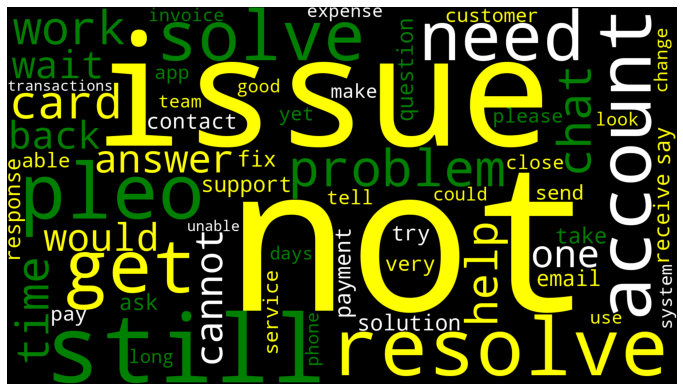

In [112]:
%matplotlib inline

colors = ["white", "yellow", "green"]

def get_color_func(word, **kwargs):
    return colors[topic_profile[phi_top_words.index == word].argmax()]

plt.figure(figsize=(12, 9))
kwargs = {
    'width': 1600,
    'height': 900,
    'min_font_size': 10
}
word_cloud = wordcloud.WordCloud(
    color_func=get_color_func, **kwargs
).generate_from_frequencies(phi_top_words.sum(axis=1))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

The three extracted theme makes sense at first glance:

 - <span style="color: #FFFF00">Yellow</span> general one with the feedback from customers whose issue was not solved
 - <span style="color: #008000">Green</span> more formal feedback with a direct pretension to Pleo on the field of too long waiting for a solution
 - <span style="color: #FFFFFF">White</span> specific customer issues with account, system or expense transaction

It's time to name the topics then and take a look at the prior distribution, note that the general theme is more popular as expected from a common sense

In [122]:
topic_labels = [
    "Specific feedback - Particular account or payment problem",
    "General negative customer experience - Issue was not duly resolved",
    "Formal direct feedback - Pleo service takes too much time",
]

topic_prior.assign(
    Label = topic_labels
).reset_index().set_index("Label").sort_values(
    by = 'p(t)', ascending=False
)[['p(t)']].apply(round, args=(2,))

p(t)
Label                                                   
General negative customer experience - Issue wa...  0.42
Formal direct feedback - Pleo service takes too...  0.35
Specific feedback - Particular account or payme...  0.24

Here are examples of review for each of the topic which quite good reflect their naming

In [1004]:
for i, nm in enumerate(topic_labels):
    print(i, nm)
    for comment in df.loc[
        indexes[theta.T.values.argsort()[:, -1] == i], "comments"
    ].sample(1):
        print(comment)
    print()

0 Specific feedback - Particular acccount or payment problem
when verifying my email. The link has expired? This has been consistent for the last 24hours. Please help.

1 General negative cusomer experience - Issue was not duly resolved
Didn't help and it still isn't resolved

2 Formal direct feedback - Pleo service takes too much time
figured it out myself before anyone got back to me 



## Conclusion

Using the excerpt of the data that is provided, it is barely possible to draw conclusions for the whole feedback population, like the positive reviews prevail over negative, but other in a way even more fruitful insight might be highlighted

 1. The primitive one which permeates the entire analysis is that general customer satisfaction highly depend on whether their problem was finally resolved and especially the speed of this solution makes difference

 2. In addition from sentiment analysis it comes that the majority of reviews where the customer writes about chatbot `sonja` is positive, of course it doesn’t necessarily mean that this bot is very helpful, it might be that clients just don’t mention its name within the negative reviews, for example because of the ask to leave a comment is formulated in a different way after customer rate the support as 0 starts. Here more domain and business field knowledge are required to have an ultimate judgment, without such an expertise the bot looks useful at first glance

 3. When it comes to improvement focuses on the basis of topic modelling approach it might be concluded that the negative feedback has 3 main categories (with examples):
   - Specific feedback - Particular account or payment problem
   > When verifying my email. The link has expired? This has been consistent for the last 24hours. Please help.
   - General negative customer experience - Issue was not duly resolved
   > Didn't help and it still isn't resolved
   - Formal direct feedback - Pleo service takes too much time
   > Figured it out myself before anyone got back to me 

While the first type of negative is totally reasonable its share among negative reviews is only about a quarter, it looks like the company should take an effort towards their customer support process enhancement, particular initiatives may consist of but are not limited to:
 - FAQ documentation provisioning with an automatic answer right after review was submitted to provide customer with a potential solution quickly, not every complaint need an operator presence to be resolved
 - chatbot rolling out to provide answers to basic questions quickly and automatically
 - the simple system using just the keywords might be released to catch reviews where the client used company name for example as it most likely means some formal claim and it’s risky from the perspective of losing such a customer after all or another example if customer within the review use wording like `months` or `weeks` probably it means that this case takes too much time and should be prioritized among others to mitigate client’s discontent
 - finally if none of the above is applicable - increase in support staff, as a straightforward solution

## Additional Information

More information on tokenizers

 - [Stemming vs Lemmatization: must know differences](https://www.analyticsvidhya.com/blog/2022/06/stemming-vs-lemmatization-in-nlp-must-know-differences/)
 - [Stemming vs Lemmatization in Python Examples](https://www.datacamp.com/tutorial/stemming-lemmatization-python)
 - [Snowball Stemmer Overview](https://www.geeksforgeeks.org/snowball-stemmer-nlp/)

Transformers Applications

 - [Sentiment analysis in Python using Transformers](https://huggingface.co/blog/sentiment-analysis-python)


Shap Documentation

 - [Shap sentiment analysis](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html)
 - [Shap emotion classification](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html#Plotting-the-top-words-impacting-a-specific-class)